In [2]:
!python --version

Python 3.12.7


In [12]:
from transformers import BertTokenizer, TFBertForSequenceClassification
import pandas as pd
import numpy as np
import torch
import os
import re
from nltk.stem import SnowballStemmer #used for stemming
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, log_loss
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt 
import spacy #used to identify aspects in the text 

In [4]:
os.getcwd()

'C:\\Users\\Chris\\Documents\\Old_Laptop_Data\\Desktop\\College Work\\Intro to Machine Learning\\Final Project'

In [5]:
data = pd.read_csv("C:\\Users\\Chris\\Documents\\Old_Laptop_Data\\Desktop\\College Work\\Intro to Machine Learning\\Final Project\\Restaurant_Customer_Reviews\\Restaurant_Reviews.csv", encoding='iso-8859-1')
data.head()
#If review is positive Liked = 1 and if review is negative Liked = 0

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [6]:
data.describe()

,Liked
count,1000.00000
mean,0.50000
std,0.50025
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


<BarContainer object of 2 artists>

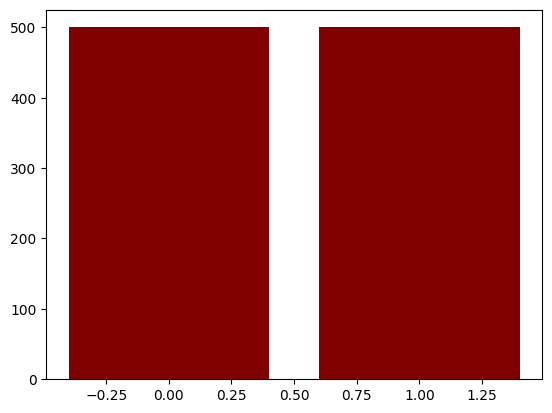

In [23]:
num_zeros = len(data) - data['Liked'].sum()
Liked = [0, 1]
plt.bar(Liked, (num_zeros, data['Liked'].sum()), color='maroon')

In [29]:
model_name = 'bert-large-uncased'#I chose bert-large-uncased because its more accurate than bert-base-uncased but more computationally expensive because it has more parameters to tune while bert-base-uncased is less accurate but less computationally expensive
epochs = 5
alpha = 0.01
batch_size = 32
tokenizer = BertTokenizer.from_pretrained(model_name)
model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
model

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
highest_len = 149
token_arr = np.empty([5])
column_name = ['input_ids']
token_data = pd.DataFrame(columns=column_name)

#Remove all punctuation and extra spaces from each restaurant review then tokenize each review and add it to dataset
for i in range(len(data['Review'])):
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', data.loc[i, 'Review'])
    clean_text = " ".join(cleaned_text.split())
    data.loc[i, 'Review'] = clean_text
    token_text = tokenizer(data.loc[i, "Review"])
    token_data.loc[i, 'input_ids'] = token_text['input_ids']

    
token_data_decode = tokenizer.decode(token_data.loc[0, 'input_ids'], skip_special_tokens=True)
print("Value of token_data_decode is: ", token_data_decode)
token_data_decode = tokenizer.decode(token_data.loc[1, 'input_ids'], skip_special_tokens=True)
print("Value of token_data_decode is now: ", token_data_decode)
token_data_decode = tokenizer.decode(token_data.loc[2, 'input_ids'], skip_special_tokens=True)
print("Value of token_data_decode now is: ", token_data_decode)
token_data_decode = tokenizer.decode(token_data.loc[3, 'input_ids'], skip_special_tokens=True)
print("Now the value of token_data_decode is: ", token_data_decode)
token_data_decode = tokenizer.decode(token_data.loc[4, 'input_ids'], skip_special_tokens=True)
print("And now the value of token_data_decode is: ", token_data_decode)
token_data
#input_ids show the token_id #'s of each word, the token_type_ids show
#token_type_ids are used to differentiate between different segments of text in a sentence
#attention_masks show which words the tokenizer will pay attention to if it = 1 then it will pay attention to it if it = 0 then it won't pay attention to it
#I train the model with attention masks because then it'll know which tokens to pay attention to and which ones to ignore

Value of token_data_decode is:  wow loved this place
Value of token_data_decode is now:  crust is not good
Value of token_data_decode now is:  not tasty and the texture was just nasty
Now the value of token_data_decode is:  stopped by during the late may bank holiday off rick steve recommendation and loved it
And now the value of token_data_decode is:  the selection on the menu was great and so were the prices


,input_ids
0,"[101, 10166, 3866, 2023, 2173, 102]"
1,"[101, 19116, 2003, 2025, 2204, 102]"
2,"[101, 2025, 11937, 21756, 1998, 1996, 14902, 2..."
3,"[101, 3030, 2011, 2076, 1996, 2397, 2089, 2924..."
4,"[101, 1996, 4989, 2006, 1996, 12183, 2001, 230..."
...,...
995,"[101, 1045, 2228, 2833, 2323, 2031, 14894, 199..."
996,"[101, 18923, 6880, 2908, 102]"
997,"[101, 3452, 1045, 2001, 2025, 7622, 1998, 2052..."
998,"[101, 1996, 2878, 3325, 2001, 2104, 2860, 2454..."


In [8]:
data.insert(1, 'tokens', token_data)
data.drop('Review', axis=1, inplace=True)
data

,tokens,Liked
0,"[101, 10166, 3866, 2023, 2173, 102]",1
1,"[101, 19116, 2003, 2025, 2204, 102]",0
2,"[101, 2025, 11937, 21756, 1998, 1996, 14902, 2...",0
3,"[101, 3030, 2011, 2076, 1996, 2397, 2089, 2924...",1
4,"[101, 1996, 4989, 2006, 1996, 12183, 2001, 230...",1
...,...,...
995,"[101, 1045, 2228, 2833, 2323, 2031, 14894, 199...",0
996,"[101, 18923, 6880, 2908, 102]",0
997,"[101, 3452, 1045, 2001, 2025, 7622, 1998, 2052...",0
998,"[101, 1996, 2878, 3325, 2001, 2104, 2860, 2454...",0


In [9]:
X = data['tokens']
X = pad_sequences(X, padding='post')
y = data['Liked']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True)

In [30]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_history = model.fit(x_train, y_train, batch_size, epochs, validation_data=(x_test, y_test))

Epoch 1/5
25/25 [==============================] - 161s 5s/step - loss: 7.2868 - accuracy: 0.5088 - val_loss: 7.6795 - val_accuracy: 0.3750
Epoch 2/5
25/25 [==============================] - 131s 5s/step - loss: 7.6658 - accuracy: 0.5312 - val_loss: 7.6795 - val_accuracy: 0.3750
Epoch 3/5
25/25 [==============================] - 130s 5s/step - loss: 7.3453 - accuracy: 0.5088 - val_loss: 3.1924 - val_accuracy: 0.6250
Epoch 4/5
25/25 [==============================] - 129s 5s/step - loss: 6.6994 - accuracy: 0.4688 - val_loss: 7.6795 - val_accuracy: 0.6250
Epoch 5/5
25/25 [==============================] - 133s 5s/step - loss: 7.6658 - accuracy: 0.4688 - val_loss: 7.6795 - val_accuracy: 0.6250


In [11]:
log_reg = LogisticRegression(solver='liblinear', random_state=42)
log_reg.fit(x_train, y_train)
y_proba = log_reg.predict(x_test)
train_acc = log_reg.score(x_train, y_train)#Get training accuracy
print("Value of training accuracy is: ", train_acc)
train_loss = log_loss(y_train, log_reg.predict_proba(x_train))#Get training loss
print("Value of training loss is: ", train_loss)
accuracy = accuracy_score(y_test, y_proba)#Get validation accuracy
print("Value of validation accuracy is: ", accuracy)
valid_loss = log_loss(y_test, log_reg.predict_proba(x_test))
print("Value of validation loss is: ", valid_loss)

Value of training accuracy is:  0.58125
Value of training loss is:  0.6495489814214019
Value of validation accuracy is:  0.4
Value of validation loss is:  0.8476893256017405


In [26]:
vocab_size = 30000  # Number of unique words to consider
max_len = 100  # Maximum length of each review (padding/truncation)

print(x_train.shape)
rnn_model = keras.models.Sequential([                        
    keras.layers.Embedding(input_dim=vocab_size, output_dim=32, input_length=35),   # Embedding layer  
    keras.layers.SimpleRNN(64, dropout=0.3, activation="relu"),                    #RNN layer, hidden vector size 64
    keras.layers.Dense(1, activation="sigmoid")                       #Output layer, binary classification with 1 neuron and sigmoid
])

rnn_model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])
rnn_history = rnn_model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test))#validation_split=0.2)

(800, 35)
Epoch 1/10
13/13 [==============================] - 1s 19ms/step - loss: 0.6935 - accuracy: 0.5063 - val_loss: 0.7021 - val_accuracy: 0.3750
Epoch 2/10
13/13 [==============================] - 0s 6ms/step - loss: 0.6918 - accuracy: 0.5312 - val_loss: 0.7097 - val_accuracy: 0.3750
Epoch 3/10
13/13 [==============================] - 0s 6ms/step - loss: 0.6917 - accuracy: 0.5312 - val_loss: 0.7069 - val_accuracy: 0.3750
Epoch 4/10
13/13 [==============================] - 0s 7ms/step - loss: 0.6914 - accuracy: 0.5312 - val_loss: 0.7095 - val_accuracy: 0.3750
Epoch 5/10
13/13 [==============================] - 0s 7ms/step - loss: 0.6915 - accuracy: 0.5312 - val_loss: 0.7126 - val_accuracy: 0.3750
Epoch 6/10
13/13 [==============================] - 0s 6ms/step - loss: 0.6912 - accuracy: 0.5312 - val_loss: 0.7108 - val_accuracy: 0.3750
Epoch 7/10
13/13 [==============================] - 0s 7ms/step - loss: 0.6916 - accuracy: 0.5312 - val_loss: 0.7034 - val_accuracy: 0.3750
Epoch 8/1